In [2]:
import pydub
import numpy as np
import sounddevice as sd
import cmath
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write
from math import e
from scipy.signal import lfilter

class Music:
    @staticmethod
    def read_mp3(filename, normalized=False):
        """
            MP3 to numpy array
        """
        a = pydub.AudioSegment.from_mp3(filename)
        y = np.array(a.get_array_of_samples())
        if a.channels == 2:
            y = y.reshape((-1, 2))
        if normalized:
            return a.frame_rate, np.float32(y) / 2**15
        else:
            return a.frame_rate, y
    
    @staticmethod
    def write_mp3(filename, Fs, x, normalized=False):
        """ 
            numpy array to MP3 
        """
        channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
        if normalized:  
            y = np.int16(x * 2 ** 15)
        else:
            y = np.int16(x)
        song = pydub.AudioSegment(y.tobytes(), frame_rate=Fs, sample_width=2, channels=channels)
        song.export(filename, format="mp3", bitrate="320k")
        return
    
# plotter function
def freqplot(y, fs, N, t1="The signal", t2="Frequency"):

    x = np.linspace(0, y.shape[0]/fs, y.shape[0]) 
    f = np.fft.fft(y)
    p = np.linspace(0, fs, y.shape[0])

    plt.figure(figsize=(30, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(x, y)
    plt.grid(True)
    plt.xlabel("Time")
    plt.title(t1)
    
    plt.subplot(2, 1, 2)
    plt.plot(p[:N], np.abs(f[:N]))
    plt.grid(True)
    plt.xlabel("Frequency")
    plt.title(t2)
    plt.show()

# Phaser Effect

Creating the parameters of n cascade all-pass filters with feedback:

In [234]:
feedback = -0.8
n = 3

b = np.zeros(n+1)
b[0] = feedback
b[n] = 1

a = np.zeros(n+1)
a[0] = 1
a[n] = feedback

Optional: Recording an audio (This part is optional and if you already have a audio you can ignore this part)

In [260]:
fs = 44100  # Sample rate
seconds = 6  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
Music.write_mp3('musics/phaser_before.mp3', fs, myrecording, normalized=True)
sd.play(myrecording, fs)
sd.wait()

Reading audio:

In [261]:
fs, data = Music.read_mp3('musics/phaser_before.mp3', True)
#sd.play(data, fs)
#sd.wait()

Applying the filter:

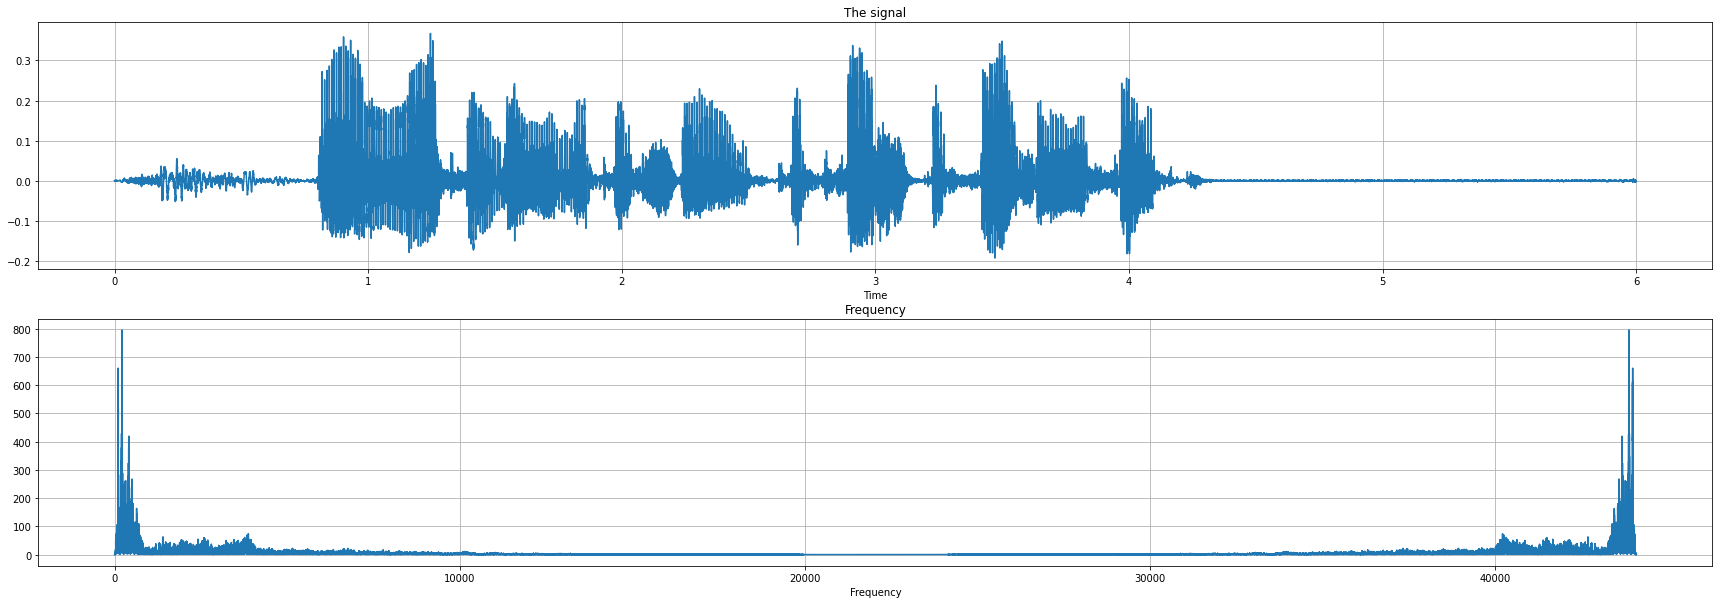

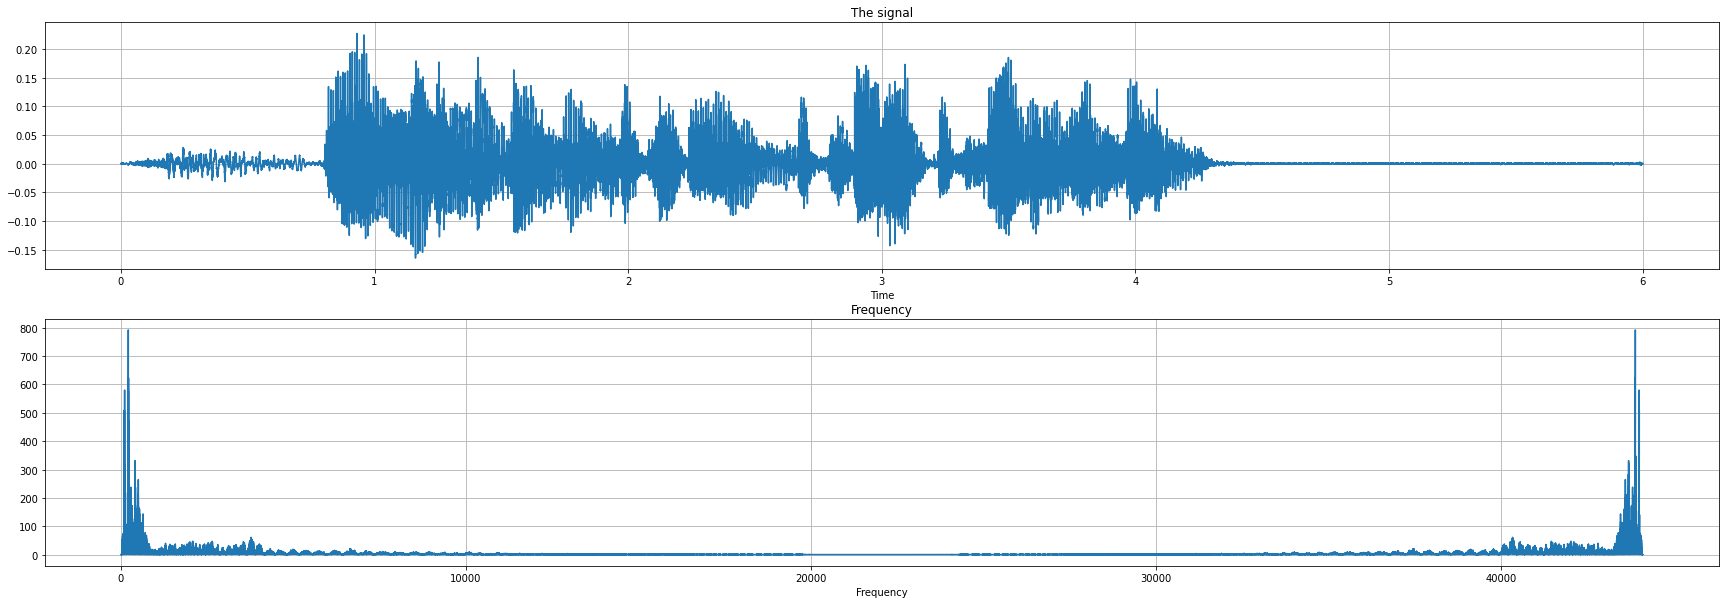

In [267]:
repeats = 280
current_data = lfilter(b, a, data/2)
for i in range(repeats):
    next_data = lfilter(b, a, current_data)
    current_data = next_data
final_data = current_data + data/2
sd.play(final_data, fs)
sd.wait()
Music.write_mp3('musics/phaser_after.mp3', fs, final_data, normalized=True)
freqplot(data, fs, data.shape[0])
freqplot(final_data, fs, final_data.shape[0])